In [3]:
%load_ext jupyter_black

In [56]:
import warnings
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from gc import collect
from IPython.display import display_html, clear_output
from typing import Optional
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_theme(style="darkgrid")

In [57]:
class myTextFormatter:
    """
    A simple text formatter class that provides colorama-based text formatting.

    This class initializes colorama settings for text formatting with various colors.

    Attributes:
        CLR (str): Black text with bright style.
        RED (str): Red text with bright style.
        BLUE (str): Blue text with bright style.
        CYAN (str): Cyan text with bright style.
        RESET (str): Reset all formatting and colors.

    Example:
        formatter = myTextFormatter()
        print(formatter.RED + "This is a red text." + formatter.RESET)

    Note:
        This class requires the `colorama` module to be installed.
    """

    def __init__(self):

        from colorama import init, Fore, Style

        # init(autoreset=True)

        # Colorama settings.
        self.CLR = Style.BRIGHT + Fore.BLACK
        self.RED = Style.BRIGHT + Fore.RED
        self.BLUE = Style.BRIGHT + Fore.BLUE
        self.CYAN = Style.BRIGHT + Fore.CYAN
        self.RESET = Style.RESET_ALL

        # Underline text
        self.U_START = "\033[4m"
        self.U_END = "\033[0m"

        self.FONT_COLOR = "#2F486B"
        self.BACKGROUND_COLOR = "#FFFCFA"

        self.CELL_HOVER = {  # for row hover use <tr> instead of <td>
            "selector": "td:hover",
            "props": "background-color: #FFFCFA",
        }
        self.TEXT_HIGHLIGHT = {
            "selector": "td",
            "props": "color: #DCEEF0; background-color: #757E7F; font-weight: bold",
        }
        self.INDEX_NAMES = {
            "selector": ".index_name",
            "props": "font-style: italic; background-color: #2F486B; color: #FFFCFA;",
        }
        self.HEADERS = {
            "selector": "th:not(.index_name)",
            "props": "font-style: italic; background-color: #2F486B; color: #FFFCFA;",
        }
        self.DF_STYLE = (self.INDEX_NAMES, self.HEADERS, self.TEXT_HIGHLIGHT)
        self.DF_CMAP = sns.light_palette("#D4D0A9", as_cmap=True)


def pretty_print(text, color):
    print(color + text + myTextFormatter().RESET)


def pretty_print_html(text, color, font_size=16):
    """
    Pretty print text with customizable color and font size.

    Args:
        text (str): The text to print.
        color (str): The color (as a CSS value) to apply.
        font_size (int): The font size for the printed text.
    """
    # Format the text with font size and color
    formatted_text = (
        f'<span style="color:{color}; font-size:{font_size}px;">{text}</span>'
    )

    # Display the text as HTML
    display_html(formatted_text, raw=True)


def DisplayAdjTbl(*args):
    """
    This function displays pandas tables in an adjacent manner, sourced from the below link-
    https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """

    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)
    collect()


formatter = myTextFormatter()

In [58]:
def get_null_stats(train, test):
    pretty_print_html(
        text="Train & Test Datasets NULL Stats".center(100, "="), color="grey"
    )
    a = pd.DataFrame(
        np.c_[train.isna().sum(), (train.isna().sum() / len(train)) * 100],
        columns=["# of nulls", "% of nulls"],
    )
    a.index.name = "Train"
    b = pd.DataFrame(
        np.c_[test.isna().sum(), (test.isna().sum() / len(test)) * 100],
        columns=["# of nulls", "% of nulls"],
    )
    b.index.name = "Test"

    DisplayAdjTbl(
        *[
            a.style.set_table_styles(formatter.DF_STYLE),
            b.style.set_table_styles(formatter.DF_STYLE),
        ]
    )


def get_unique_stats(train, test):
    pretty_print_html(
        text="Train & Test Datasets Unique Stats".center(100, "="), color="grey"
    )

    a = pd.DataFrame(
        train.nunique(),
        columns=["# of uniques"],
    )
    a.index.name = "Train"
    b = pd.DataFrame(
        test.nunique(),
        columns=["# of uniques"],
    )
    b.index.name = "Test"

    DisplayAdjTbl(
        *[
            a.style.set_table_styles(formatter.DF_STYLE),
            b.style.set_table_styles(formatter.DF_STYLE),
        ]
    )


def get_datasets_info(train, test):
    pretty_print_html(text="Train & Test Datasets INFO".center(100, "="), color="grey")

    def foramat_info_str(info_str, index_name):
        # Parse the info string to extract relevant details
        lines = info_str.splitlines()

        # Extract column details (skip first 3 lines and last 2 lines)
        info_data = []
        index = []
        for i, line in enumerate(lines[3:-2]):
            if i < 2:
                continue
            parts = line.split()
            index.append(parts[0])
            col_name = parts[1]
            non_null_count = parts[2]
            dtype = parts[-1]
            info_data.append([col_name, non_null_count, dtype])

        # Create a DataFrame with the parsed information
        info_df = pd.DataFrame(
            info_data,
            columns=["Column", "Non-Null Count", "Dtype"],
            index=index,
        )
        info_df.index.name = index_name

        # Optionally, add total memory usage (from the last line)
        memory_usage = lines[-1].split(": ")[-1]
        info_df.loc["Total Memory Usage"] = ["", "", memory_usage]

        return info_df.style.set_table_styles(formatter.DF_STYLE)

    # Capture the output of df.info() into a string buffer
    buffer = io.StringIO()
    train.info(buf=buffer)
    train_info_str = buffer.getvalue()

    buffer = io.StringIO()
    test.info(buf=buffer)
    test_info_str = buffer.getvalue()

    DisplayAdjTbl(
        *[
            foramat_info_str(train_info_str, "Train Info"),
            foramat_info_str(test_info_str, "Test Info"),
        ]
    )


def get_descibe_stats(train, test):
    pretty_print_html(
        text="Train & Test Datasets Describe Stats".center(100, "="), color="grey"
    )
    a = train.describe()
    a.index.name = "Train"

    b = test.describe()
    b.index.name = "Test"
    DisplayAdjTbl(
        *[
            a.style.set_table_styles(formatter.DF_STYLE),
            b.style.set_table_styles(formatter.DF_STYLE),
        ]
    )


def plot_countplot(
    train: pd.DataFrame,
    test: Optional[pd.DataFrame],
    col: str,
    topN: Optional[int] = None,
) -> None:
    """
    Plots count plots of a specified column from the training and optionally the test dataset.

    Args:
        train (pd.DataFrame): The training dataset.
        test (Optional[pd.DataFrame]): The test dataset. If None, only the training dataset is plotted.
        col (str): The column to plot the count plot for.
        topN (Optional[int]): Limits the plot to the top N categories if provided.

    Returns:
        None
    """
    train_order = train[col].value_counts().index

    if test is not None:
        test_order = test[col].value_counts().index

    if topN:
        train_order = train_order[0:topN]
        test_order = test_order[0:topN]

    if test is not None:
        r = 1
        c = 2
        s = (22, 3)
    else:
        r = 1
        c = 1
        s = (11, 6)

    fig, axes = plt.subplots(r, c, figsize=s)
    if test is not None:
        sns.countplot(data=train, x=col, ax=axes[0], order=train_order)
        sns.countplot(data=test, x=col, ax=axes[1], order=test_order)
        axes[0].set_title(f"{col} in Train Dataset")
        axes[1].set_title(f"{col} in Test Dataset")
        plt.setp(axes[0].get_xticklabels(), rotation=60, ha="right")
        plt.setp(axes[1].get_xticklabels(), rotation=60, ha="right")
        plt.show()
    else:
        sns.countplot(data=train, x=col, ax=axes, order=train_order)
        axes.set_title(f"{col} in Train Dataset")
        plt.setp(axes.get_xticklabels(), rotation=60, ha="right")
        plt.show()

In [59]:
orig_train = pd.read_csv("inputs/train.csv")
orig_test = pd.read_csv("inputs/test.csv")

label = "target"
train = orig_train.drop(columns=[label])
y = orig_train[label]

test = orig_test.copy()

In [60]:
get_datasets_info(train, test)

get_null_stats(train, test)

get_descibe_stats(train, test)

get_unique_stats(train, test)

=====================================Train & Test Datasets INFO=====================================

,Column,Non-Null Count,Dtype
Train Info,,,
0,id,7613,int64
1,keyword,7552,object
2,location,5080,object
3,text,7613,object
Total Memory Usage,,,238.0+ KB
,Column,Non-Null Count,Dtype
Test Info,,,
0,id,3263,int64
1,keyword,3237,object


==================================Train & Test Datasets NULL Stats==================================

,# of nulls,% of nulls
Train,,
0,0.000000,0.000000
1,61.000000,0.801261
2,2533.000000,33.272035
3,0.000000,0.000000
,# of nulls,% of nulls
Test,,
0,0.000000,0.000000
1,26.000000,0.796813
2,1105.000000,33.864542


================================Train & Test Datasets Describe Stats================================

,id
Train,
count,7613.000000
mean,5441.934848
std,3137.116090
min,1.000000
25%,2734.000000
50%,5408.000000
75%,8146.000000
max,10873.000000
,id


=================================Train & Test Datasets Unique Stats=================================

,# of uniques
Train,
id,7613
keyword,221
location,3341
text,7503
,# of uniques
Test,
id,3263
keyword,221
location,1602


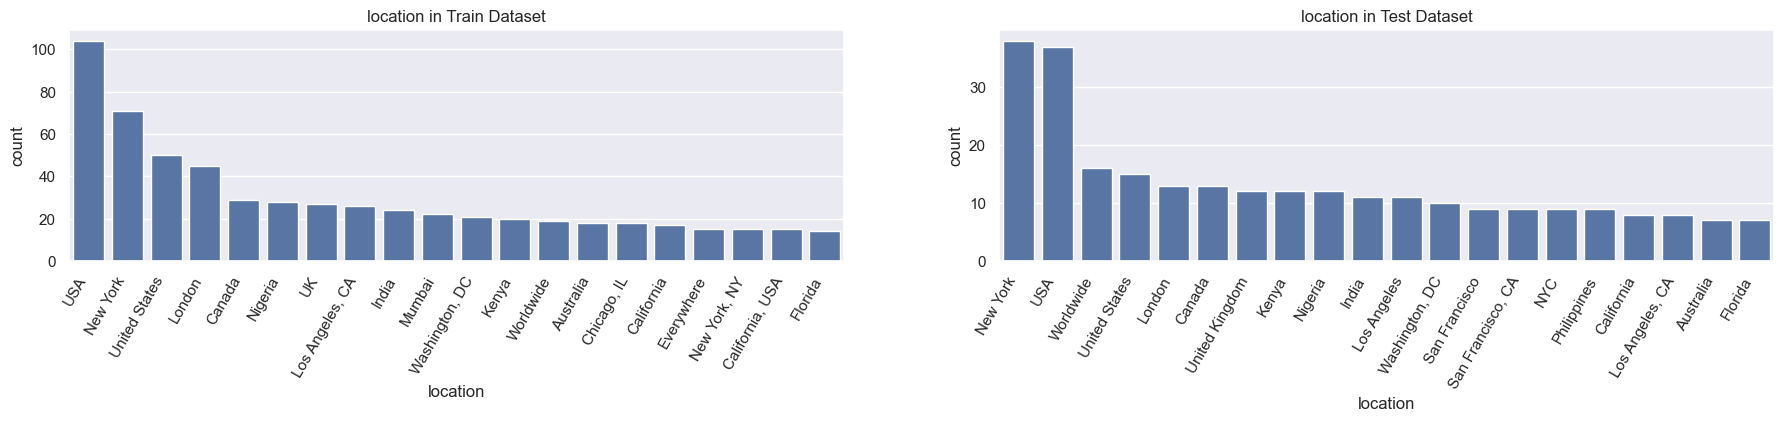

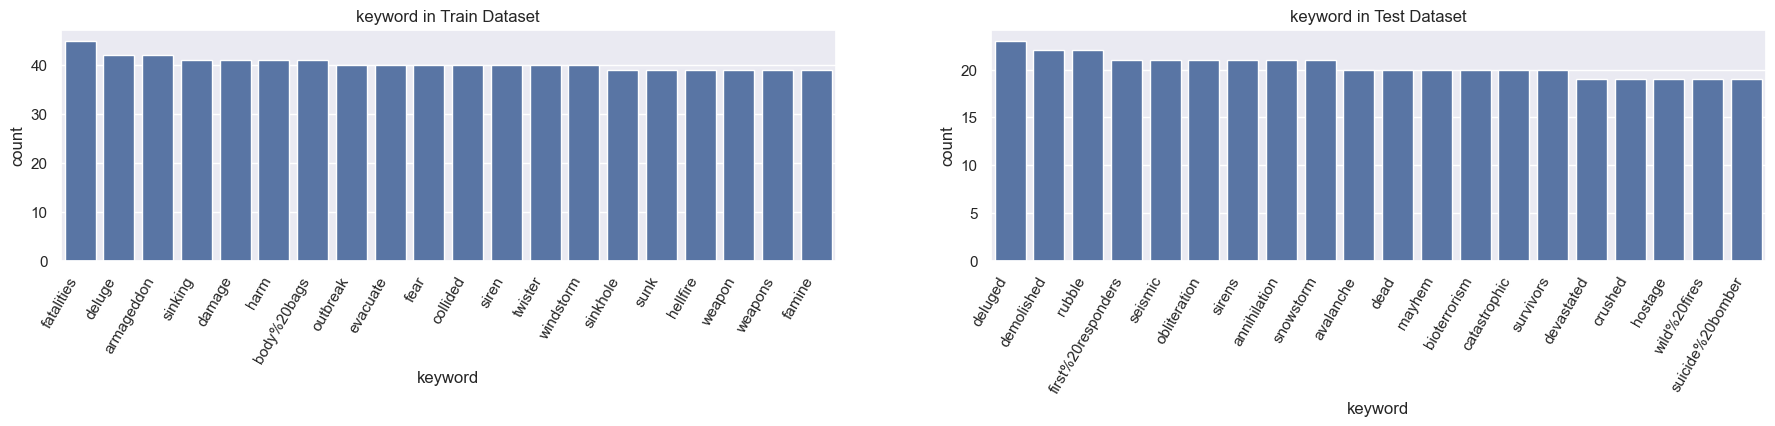

In [61]:
plot_countplot(train, test, "location", topN=20)
plot_countplot(train, test, "keyword", topN=20)

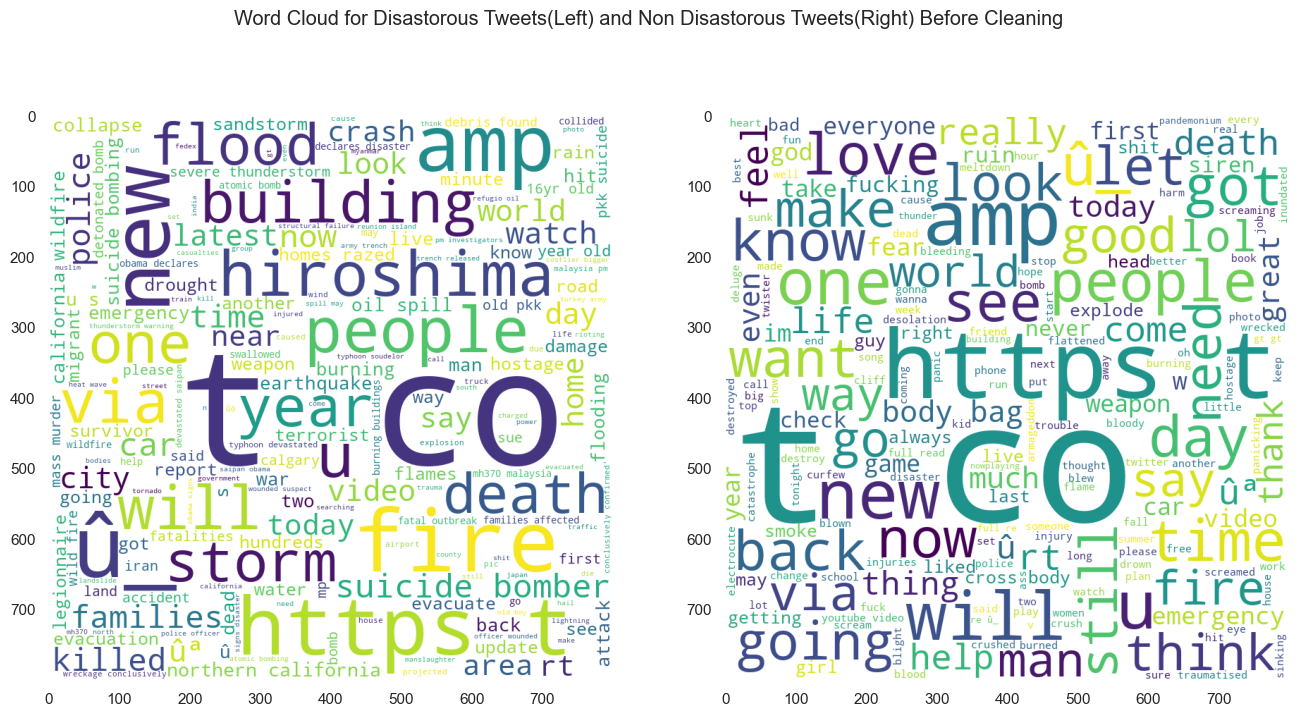

In [62]:
non_disastorous_tweets = ""
disastorous_tweets = ""
stopwords = set(STOPWORDS)

for val in train.loc[y == 1].text:
    tokens = [i.lower() for i in val.split()]
    disastorous_tweets += " ".join(tokens) + " "

for val in train.loc[y == 0].text:
    tokens = [i.lower() for i in val.split()]
    non_disastorous_tweets += " ".join(tokens) + " "

wordcloud_disastorous_tweets = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(disastorous_tweets)

wordcloud_non_disastorous_tweets = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(non_disastorous_tweets)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_disastorous_tweets)
axes[1].imshow(wordcloud_non_disastorous_tweets)
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle(
    "Word Cloud for Disastorous Tweets(Left) and Non Disastorous Tweets(Right) Before Cleaning"
)
plt.show()

In [63]:
for df in [train, test]:
    df.drop(columns=["location", "keyword", "id"], inplace=True)

In [64]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [65]:
import tensorflow as tf
import keras_core as keras
import keras_nlp

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.17.0
KerasNLP version: 0.14.4


In [66]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES) * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [68]:
from sklearn.model_selection import train_test_split

X = train["text"]
y = y

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SPLIT, random_state=42
)

X_test = test["text"]

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [69]:
# Load a DistilBERT model.
preset = "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset, sequence_length=160, name="preprocessor_4_tweets"
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset, preprocessor=preprocessor, num_classes=2
)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_4 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),  #'binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

# Fit
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
)

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 2140s 11s/step - accuracy: 0.5567 - loss: 0.7217 - val_accuracy: 0.5739 - val_loss: 0.6836
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 2494s 13s/step - accuracy: 0.5730 - loss: 0.6837 - val_accuracy: 0.5739 - val_loss: 0.6833


In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [77]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues,
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title(
        "Confusion Matrix on "
        + dataset
        + " Dataset -- F1 Score: "
        + str(f1_score.round(2))
    )
    plt.show()

191/191 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step


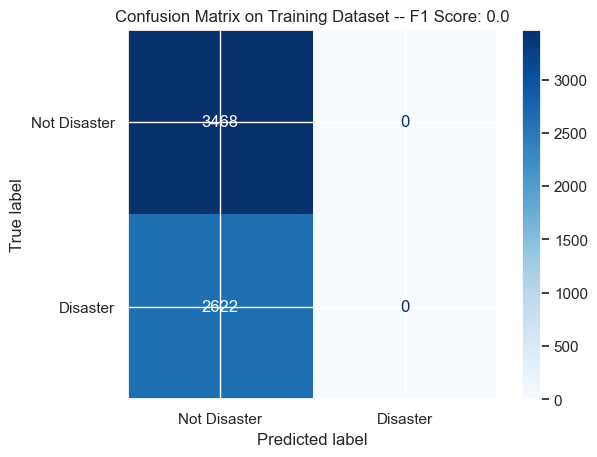

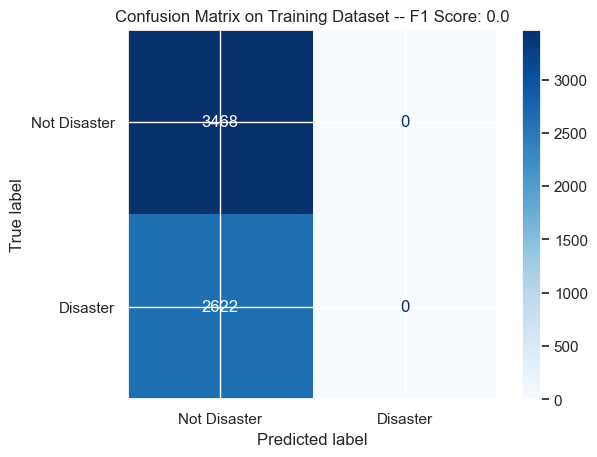

In [78]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

In [79]:
y_pred_train.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64

In [76]:
y_train

4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64